# Encoder Smoothing least squares fit

In [1]:
import sympy
import math

In [2]:
sympy.init_session()

IPython console for SymPy 1.11.1 (Python 3.10.11-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



In [3]:
def display_dict(d):
    """ Display a dict of variable: expression (eg. a result of solve)"""
    for v, expr in d.items():
        display(Eq(v, expr))

In [4]:
def factor_sums(expr):
    def cSum(s):
      con, dep = factor_terms(s.function.as_independent(*s.variables))
      return con*Sum(dep, *s.args[1:])

    return expr.expand().replace(lambda s: isinstance(s, Sum), lambda s: cSum(s))

In [5]:
dt = Symbol("Δt")
dt

In [6]:
var("a, v, x, p0, p1, p2, s_t, s_t2, s_t3, s_t4, s_y, s_ty, s_t2y, s_iy, s_i2y", real=True)

In [7]:
var("i, k", integer=True)

In [8]:
y = Function("y", real=True)

In [9]:
t = Function("t", real=True)

In [10]:
def interpolation_function(t):
    return p0 + p1 * t# + p2 * t**2

In [11]:
variables = [p0, p1, p2]

In [12]:
velocity = diff(interpolation_function(x), x).subs(x, 0)
velocity

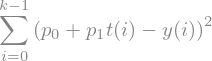

In [13]:
error = Sum((interpolation_function(t(i)) - y(i))**2, (i, 0, k-1))
error

In [14]:
#error = error.subs(y(i), (y(i) - y(i - 1)))
#error

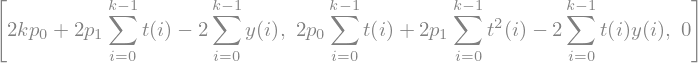

In [15]:
eqs = [factor_sums(diff(error, var)).doit() for var in variables]
eqs

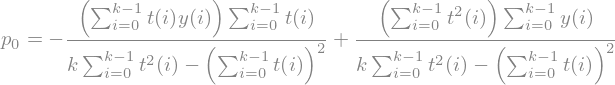

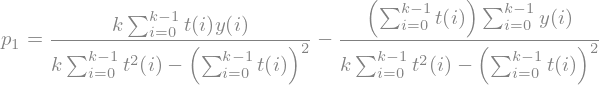

In [16]:
solution = solve(eqs, variables)
display_dict(solution)

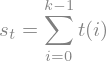

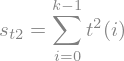

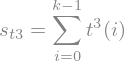

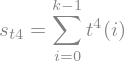

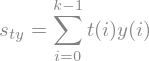

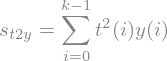

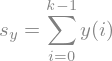

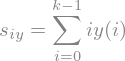

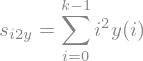

In [17]:
substitutions = { name: Sum(expr, (i, 0, k-1)) for (name, expr) in [
    (s_t, t(i)),
    (s_t2, t(i)**2),
    (s_t3, t(i)**3),
    (s_t4, t(i)**4),
    (s_ty, t(i) * y(i)),
    (s_t2y, t(i)**2 * y(i)),
    (s_y, y(i)),
    (s_iy, i * y(i)),
    (s_i2y, i**2 * y(i)),
]}
display_dict(substitutions)

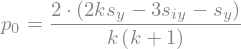

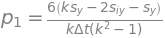

In [18]:
substituted_solution = {
    name: (
        expr
        .subs([
            (expr, substitution)
            for (substitution, expr)
            in substitutions.items()
        ])
        .simplify()
        .subs(substitutions)
        .subs(t(i), -i * dt)
        .doit()
        .subs([
            (expr, substitution)
            for (substitution, expr)
            in substitutions.items()
        ])
        .simplify()
        .subs([
            (expr, substitution)
            for (substitution, expr)
            in substitutions.items()
        ])
        .simplify()
    )
    for (name, expr) in solution.items()
}
display_dict(substituted_solution)

In [19]:
def factor_subexpressions(expr, variable):
    if expr.free_symbols == {variable}:
        return expr.factor()
    elif len(expr.args) > 0:
        return expr.func(
            *[factor_subexpressions(arg, variable) for arg in expr.args]
        )
    else:
        return expr

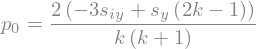

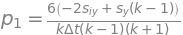

In [20]:
factored_solution = {
    var: factor_subexpressions(
        expr.collect(
            list(substitutions.keys())
        ),
        k
    )
    for (var, expr)
    in substituted_solution.items()
}
display_dict(factored_solution)